In [246]:
%load_ext autoreload
%autoreload 

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

import shared.query as q
import shared.viz as viz

from scipy import sparse
from sklearn.metrics import pairwise_distances

viz.set_style()
conn = q.connect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Recommendations

This worksheet explores the inner workings of Presto! - transforming reviews into recommendations

In [227]:
## Settings

max_product_pool_size = 10
max_user_pool_size = 20
fill_value = 0
title = 'The Lorax'


In [228]:
product = q.find_products('Books', search_term = title, conn = conn).loc[0]
product

find_products: 1 results in 1.733 seconds


id                                                     0881034185
reviews                                                       238
title           The Lorax (Turtleback School & Library Binding...
creator                                                 Tish Rabe
publisher                    Random House Books for Young Readers
description     Easy-to-read, rhyming text introduces the Lora...
release_date                                                 2012
category                                                    Books
subcategory                                      Juvenile Fiction
Name: 0, dtype: object

In [265]:
def plot_user_ratings_by_product(
        data: pd.DataFrame, 
        target_product_id: str, # to highlight the active / target product 
        conn, 
        ax = None, 
        cbar_kws = None,
        product_name_limit = 20,
        hide_y_axis_cutoff = 50,
        hide_x_axis_cutoff = 500
):    
    ax = ax or plt.gca()

    cmap = mpl.colormaps.get_cmap('Blues')
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    ax = sns.heatmap(data, vmin = 0, vmax = 5, cmap = cmap, norm = norm, ax = ax, cbar_kws = cbar_kws)

    colorbar = ax.collections[0].colorbar
    colorbar.set_label("Rating", fontsize = 15)
    colorbar.set_ticks(range(0,6))
    colorbar.set_ticklabels(['None', '★', '★★', '★★★', '★★★★', '★★★★★'], fontsize = 15)
    colorbar.outline.set_visible(True)
    colorbar.outline.set_color('k')
    for spine in ['top', 'bottom', 'left', 'right']:
        colorbar.ax.spines[spine].set_visible(True)
        ax.spines[spine].set_visible(True)

    product_names = q.get_product_details(data.index, conn = conn, select = 'title')['title']
    product_names = product_names.map(lambda title: title[:product_name_limit])
    ax.yaxis.set_ticklabels(product_names.values)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.set_label_text('User')
    ax.xaxis.set_ticklabels([f'U{i+1}' for i in range(len(data.columns))])
    ax.set_title('User Ratings Per Product', fontsize = 15)

    if data.shape[1] >= hide_x_axis_cutoff:    
        ax.xaxis.set_visible(False)
    if data.shape[0] >= hide_y_axis_cutoff:
        ax.yaxis.set_visible(False)
    
    return ax


## Get Related Reviews

Get all books that have reviewers in common with this book:

In [230]:
reviews = q.get_reviews(product.id, conn)
related_reviews = q.get_related_reviews(reviews, conn, filter_unhelpful_reviews = True, max_reviewer_count = max_user_pool_size, max_product_count = max_product_pool_size)
related_reviews[:2]

get_reviews: 238 results in 0.005 seconds
0.0525: Got 2709 related reviews of 2197 products by 187 users
0.0527: Filtered 2467 helpful related reviews
0.0548: Filtered 54 related reviews by user and/or product


,user_id,product_id,rating,upvotes,downvotes
26,A13EUSV15UDAUG,0881034185,5,19,6
34,A13EUSV15UDAUG,B0006AQ74C,5,0,0


## Filter products and reviewers

To do

## Compute Cosine Similarities

### Create Rating Table of products by reviewers

In [231]:
user_ratings_per_product = pd.pivot(
    related_reviews,
    values = 'rating',
    index = 'product_id',
    columns = 'user_id'
)
user_ratings_per_product.fillna('')

user_id,A13EUSV15UDAUG,A14WCM5XDC1UT3,A1KYJA5YM1479G,A1P0ZB4YAA312R,A25KKXUQQ0OLWB,A2M687HYOW9JFW,A2QA7AEHMMD7OC,A341BG8RMH8QW,A3I8FT707XKQAJ,A3K1JTEB70E4FV,A3O9LMY2DTV2B2,A3PJZ8TU8FDQ1K,A3PNBDW3Q5AUFM,A525O40Q3XE0L,A6HXFDIC7DVTC,A96K1ZGW56S2I,AG42CYU5P8NVQ,AS6SH2JM2YY3H,AUTBHG6070SL4,AYOJ4CX2CZP7Y
product_id,,,,,,,,,,,,,,,,,,,,
0460872702,,,,,,,,,5.0,,,,,3.0,,5.0,,,,4.0
0881034185,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,5.0,5.0,5.0
B0000CO4JZ,,,,,,,,,5.0,,,,,3.0,,5.0,,,,4.0
B0006AQ74C,5.0,,,,,,,,,5.0,,,5.0,,,5.0,,,,
B0006DJTGW,,,,5.0,,,,4.0,,,,,,,,,,,3.0,
B0006QSHNA,5.0,,,,,,,,,5.0,,,5.0,,,5.0,,,,
B0007C10MS,,,,,,,,,5.0,,,,,3.0,,5.0,,,,4.0
B0007I5RRG,,,,,,,,,,,,5.0,,,4.0,4.0,,,,
B000CNLIHE,5.0,,,,,,,,,5.0,,,5.0,,,5.0,,,,


product details 10: 10 results in 0.001 seconds


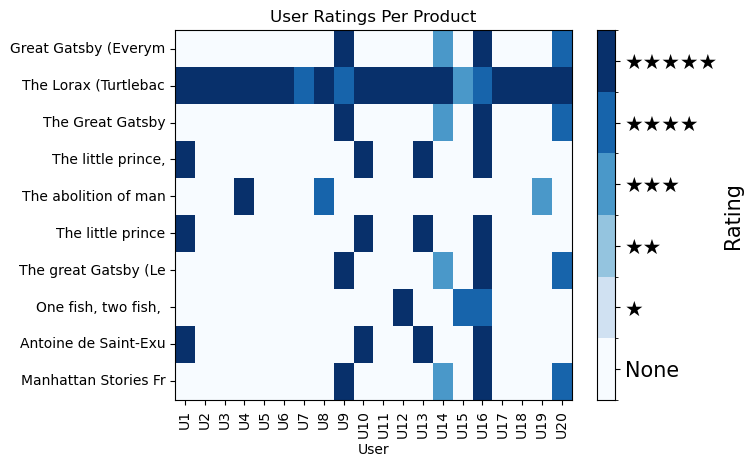

In [232]:

import matplotlib as mpl

user_ratings_per_product.fillna(fill_value, inplace = True)
plot_user_ratings_by_product(user_ratings_per_product, product.id, conn)
plt.gcf().savefig('../images/recommendation-ratings.png', bbox_inches = 'tight')

### Create Pairwise Similarity table

For each pair of products/rows in teh above rating map, find the similarity between the two rows. Output the pairwise similarities in a matrix:

In [211]:
user_ratings_per_product_sparse = sparse.csr_matrix(user_ratings_per_product.fillna(fill_value))
pairwise_cosine_similarities = pairwise_distances(user_ratings_per_product_sparse, metric = 'cosine')
user_ratings_per_product_sparse
pairwise_cosine_similarities = pd.DataFrame(pairwise_cosine_similarities, index = user_ratings_per_product.index, columns = user_ratings_per_product.index)
pairwise_cosine_similarities

product_id,0460872702,0881034185,B0000CO4JZ,B0006AQ74C,B0006DJTGW,B0006QSHNA,B0007C10MS,B0007I5RRG,B000CNLIHE,B000EANQJ8
product_id,,,,,,,,,,
0460872702,0.000000e+00,0.594890,2.220446e-16,0.711325,1.000000,0.711325,2.220446e-16,0.694112,0.711325,2.220446e-16
0881034185,5.948904e-01,0.000000,5.948904e-01,0.555609,0.603075,0.555609,5.948904e-01,0.671617,0.555609,5.948904e-01
B0000CO4JZ,2.220446e-16,0.594890,0.000000e+00,0.711325,1.000000,0.711325,2.220446e-16,0.694112,0.711325,2.220446e-16
B0006AQ74C,7.113249e-01,0.555609,7.113249e-01,0.000000,1.000000,0.000000,7.113249e-01,0.735094,0.000000,7.113249e-01
B0006DJTGW,1.000000e+00,0.603075,1.000000e+00,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00
B0006QSHNA,7.113249e-01,0.555609,7.113249e-01,0.000000,1.000000,0.000000,7.113249e-01,0.735094,0.000000,7.113249e-01
B0007C10MS,2.220446e-16,0.594890,2.220446e-16,0.711325,1.000000,0.711325,0.000000e+00,0.694112,0.711325,2.220446e-16
B0007I5RRG,6.941124e-01,0.671617,6.941124e-01,0.735094,1.000000,0.735094,6.941124e-01,0.000000,0.735094,6.941124e-01
B000CNLIHE,7.113249e-01,0.555609,7.113249e-01,0.000000,1.000000,0.000000,7.113249e-01,0.735094,0.000000,7.113249e-01


product details 10: 10 results in 0.002 seconds


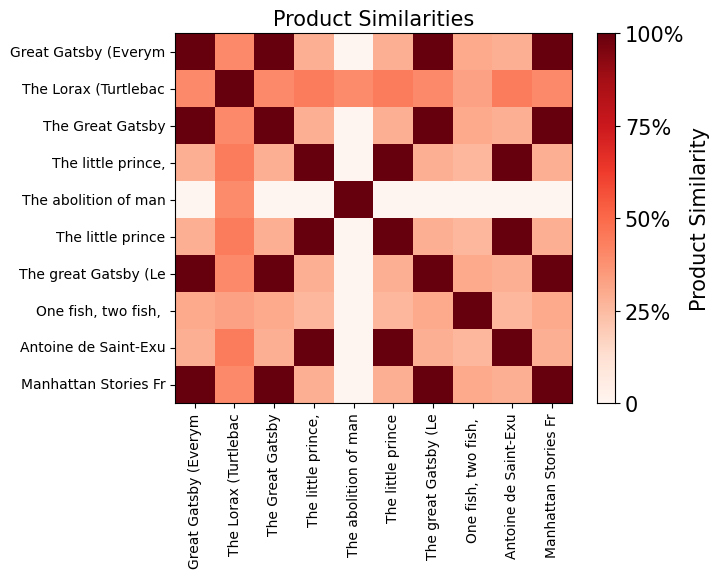

In [ ]:
def plot_pairwise_similarities(data: pd.DataFrame, id: str, conn, product_name_limit = 20, ax = None, cbar_kws = None):
    ax = ax or plt.gca()
    ax = sns.heatmap(data, vmin = 0, vmax = 1, cmap = 'Reds', ax = ax, cbar_kws = cbar_kws)
    colorbar = ax.collections[0].colorbar
    colorbar.set_label('Product Similarity', fontsize = 15)
    colorbar.set_ticks([0, .25, .5, .75, 1])
    colorbar.set_ticklabels(['0', '25%', '50%', '75%', '100%'], fontsize = 15)
    for spine in ['top', 'bottom', 'left', 'right']:
        colorbar.ax.spines[spine].set_visible(True)
        ax.spines[spine].set_visible(True)
    product_names = q.get_product_details(data.index, conn, select = 'title')['title']
    product_names = product_names.map(lambda title: title[:product_name_limit])
    ax.xaxis.set_ticklabels(product_names)
    ax.yaxis.set_ticklabels(product_names)
    ax.set_title('Product Similarities', fontsize = 15)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    return ax

pairwise_similarities = pairwise_cosine_similarities.map(lambda x: 1 - x)
plot_pairwise_similarities(pairwise_similarities, product.id, conn)    
plt.gcf().savefig('../images/recommendation-similarities.png', bbox_inches = 'tight')

Let's put the above two together into a shared plot so we can see the connection:

[<Axes: > <Axes: >]
Axes(0.125,0.11;0.352273x0.77)
Axes(0.547727,0.11;0.352273x0.77)
product details 10: 10 results in 0.001 seconds
product details 10: 10 results in 0.000 seconds


<Axes: title={'center': 'Product Similarities'}, xlabel='product_id', ylabel='product_id'>

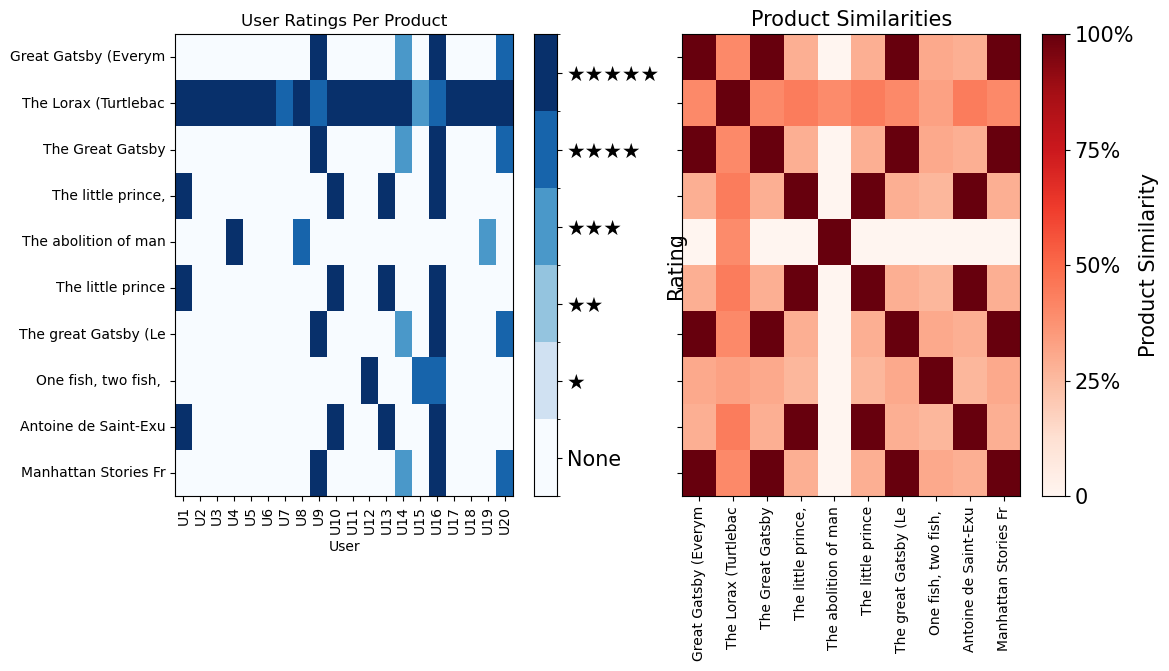

In [263]:
#plot_user_ratings_by_product(user_ratings_per_product, product.id, conn)

fig, axs = plt.subplots(1, 2, sharey = True)
print(axs)
print(axs[0])
print(axs[1])

fig.set_size_inches(12, 6)
#plot_user_ratings_by_product(user_ratings_per_product, product.id, conn, ax = axs[0])
#plot_user_ratings_by_product(user_ratings_per_product, product.id, conn, ax = axs[1])
#plot_pairwise_similarities(pairwise_similarities, product.id, conn, ax = axs[0])
#plot_pairwise_similarities(pairwise_similarities, product.id, conn, ax = axs[1])
xs = np.arange(0, 100)
#axs[0].plot(xs, xs)
#sns.heatmap(user_ratings_per_product, ax = axs[0])
plot_user_ratings_by_product(user_ratings_per_product, product.id, conn, ax = axs[0])
plot_pairwise_similarities(pairwise_similarities, product.id, conn, ax = axs[1])
#axs[1].plot(xs, xs ** 2)


#plot_user_ratings_by_product(user_ratings_per_product, product.id, conn, ax = axs[0])
#plot_pairwise_similarities(pairwise_similarities, product.id, conn, ax = axs[1])

#fig = plt.figure(figsize = (12,6))
#plt.subplot(121)
#plot_user_ratings_by_product(user_ratings_per_product, product.id, conn)
#plt.subplot(122)
#plot_pairwise_similarities(pairwise_cosine_similarities, product.id, conn, sharey = True)

In [213]:
recommendations = pairwise_cosine_similarities.loc[product.id]
results = q.get_recommendations_from_reviews(product.id, related_reviews, conn)
results

0.00225: Created ratings table for 10 products by 20 users
0.00329: Calculated similarities
0.00612: Removed 1 duplicate editions of the same product
0.00625: Added product details


,similarity,title,creator,publisher,description,category,subcategory,release_date
B0006AQ74C,0.444391,"The little prince,",Antoine de Saint-Exupery,HMH Books For Young Readers,"Hello, I am the Little Prince. Bonjour, je sui...",Books,Juvenile Fiction,2015-10-13
B000CNLIHE,0.444391,Antoine de Saint-Exupery's: The Little Prince,nan,None,None,Books,nan,None
0460872702,0.405110,Great Gatsby (Everyman),F. Scott Fitzgerald,Everyman's Library,Fitzgerald's masterpiece--the quintessential J...,Books,American Dream,2021
B0000CO4JZ,0.405110,The Great Gatsby,F. Scott Fitzgerald,Pan Macmillan,In The Great Gatsby F. Scott Fitzgerald captur...,Books,Fiction,2016-09-08
B0007C10MS,0.405110,The great Gatsby (Leading English literature l...,F. Scott Fitzgerald,Penguin,A must-have new edition of one of the great Am...,Books,Fiction,2021-01-05
B000EANQJ8,0.405110,Manhattan Stories From the Heart of a Great City,Seymour Krim,None,None,Books,"Manhattan (New York, N.Y.)",1954
B0006DJTGW,0.396925,"The abolition of man; or, Reflections on educa...","C S Lewis, C. S. (Clive Staples) Lewis, C. S. ...",Createspace Independent Publishing Platform,The Abolition of Man is a 1943 book by C. S. L...,Books,nan,2018-01-17
B0007I5RRG,0.328383,"One fish, two fish, red fish, blue fish (I can...",nan,None,None,Books,nan,None
